In [2]:
from core.network.fcn_relu import ConvolutionalNetworkReLUWithHooks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

In [44]:
def load_model(model, load_path):
    """Load the trained model weights."""
    checkpoint = torch.load(load_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

# Example usage
model = ConvolutionalNetworkReLUWithHooks()
load_path = "results/model_upgd_fo_global_label_permuted_cifar10_stats_final.pth"
model = load_model(model, load_path)
model

/var/folders/9_/ltxb073x343d3wnstb03n2nr0000gn/T/ipykernel_93857/3418540653.py:3: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



ConvolutionalNetworkReLUWithHooks(
  (conv_1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=400, out_features=120, bias=True)
  (act_1): ReLU()
  (linear_2): Linear(in_features=120, out_features=84, bias=True)
  (act_2): ReLU()
  (linear_3): Linear(in_features=84, out_features=10, bias=True)
)

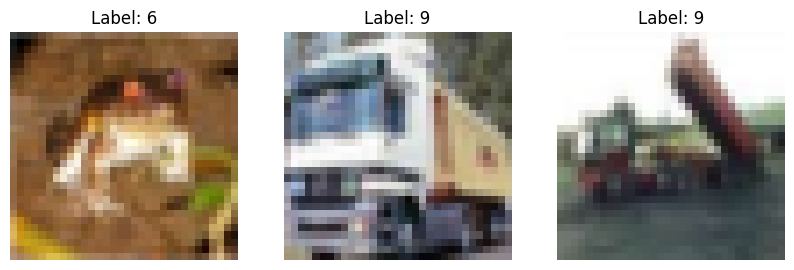

In [4]:
import pickle
import os

import matplotlib.pyplot as plt

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_batch(batch_id):
    data_path = f'dataset/cifar-10-batches-py/data_batch_{batch_id}'
    batch = unpickle(data_path)
    images = batch[b'data']
    images = images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch[b'labels']
    return images, labels

# Load the first batch
images, labels = load_cifar10_batch(1)

# Show the first 3 images
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Label: {labels[i]}')
    axes[i].axis('off')
plt.show()

In [5]:
model(torch.tensor(images[:3]).permute(0, 3, 1, 2).float())

tensor([[-287.5930, -300.2818, -105.9135, -179.1441, -139.1938,   63.5987,
          -89.8165,   93.8113, -310.3215, -299.5143],
        [-295.7073,  236.2710, -520.0079, -396.9544, -505.7468, -497.4199,
         -463.0891, -570.1995, -227.2276,   50.2384],
        [ -81.3343,   43.5471, -137.4077,  -80.8375, -135.9325, -118.7419,
         -128.9741, -131.9106,  -87.0948,   53.1039]],
       grad_fn=<AddmmBackward0>)

In [35]:
import torch

class UPGD(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-5, weight_decay=0.001, beta_utility=0.999, sigma=0.001):
        defaults = dict(lr=lr, weight_decay=weight_decay, beta_utility=beta_utility, sigma=sigma)
        super(UPGD, self).__init__(params, defaults)
    def step(self):
        global_max_util = torch.tensor(-torch.inf)
        for group in self.param_groups:
            for p in group["params"]:
                state = self.state[p]
                if len(state) == 0:
                    state["step"] = 0
                    state["avg_utility"] = torch.zeros_like(p.data)
                state["step"] += 1
                avg_utility = state["avg_utility"]
                avg_utility.mul_(group["beta_utility"]).add_(
                    -p.grad.data * p.data, alpha=1 - group["beta_utility"]
                )
                current_util_max = avg_utility.max()
                if current_util_max > global_max_util:
                    global_max_util = current_util_max
        for group in self.param_groups:
            for p in group["params"]:
                state = self.state[p]
                bias_correction_utility = 1 - group["beta_utility"] ** state["step"]
                noise = torch.randn_like(p.grad) * group["sigma"]
                scaled_utility = torch.sigmoid_((state["avg_utility"] / bias_correction_utility) / global_max_util)
                p.data.mul_(1 - group["lr"] * group["weight_decay"]).add_(
                    (p.grad.data + noise) * (1-scaled_utility),
                    alpha=-2.0*group["lr"],
                )
                state["scaled_utility"] = scaled_utility

/var/folders/9_/ltxb073x343d3wnstb03n2nr0000gn/T/ipykernel_93857/3418540653.py:3: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/var/folders/9_/ltxb073x343d3wnstb03n2nr0000g

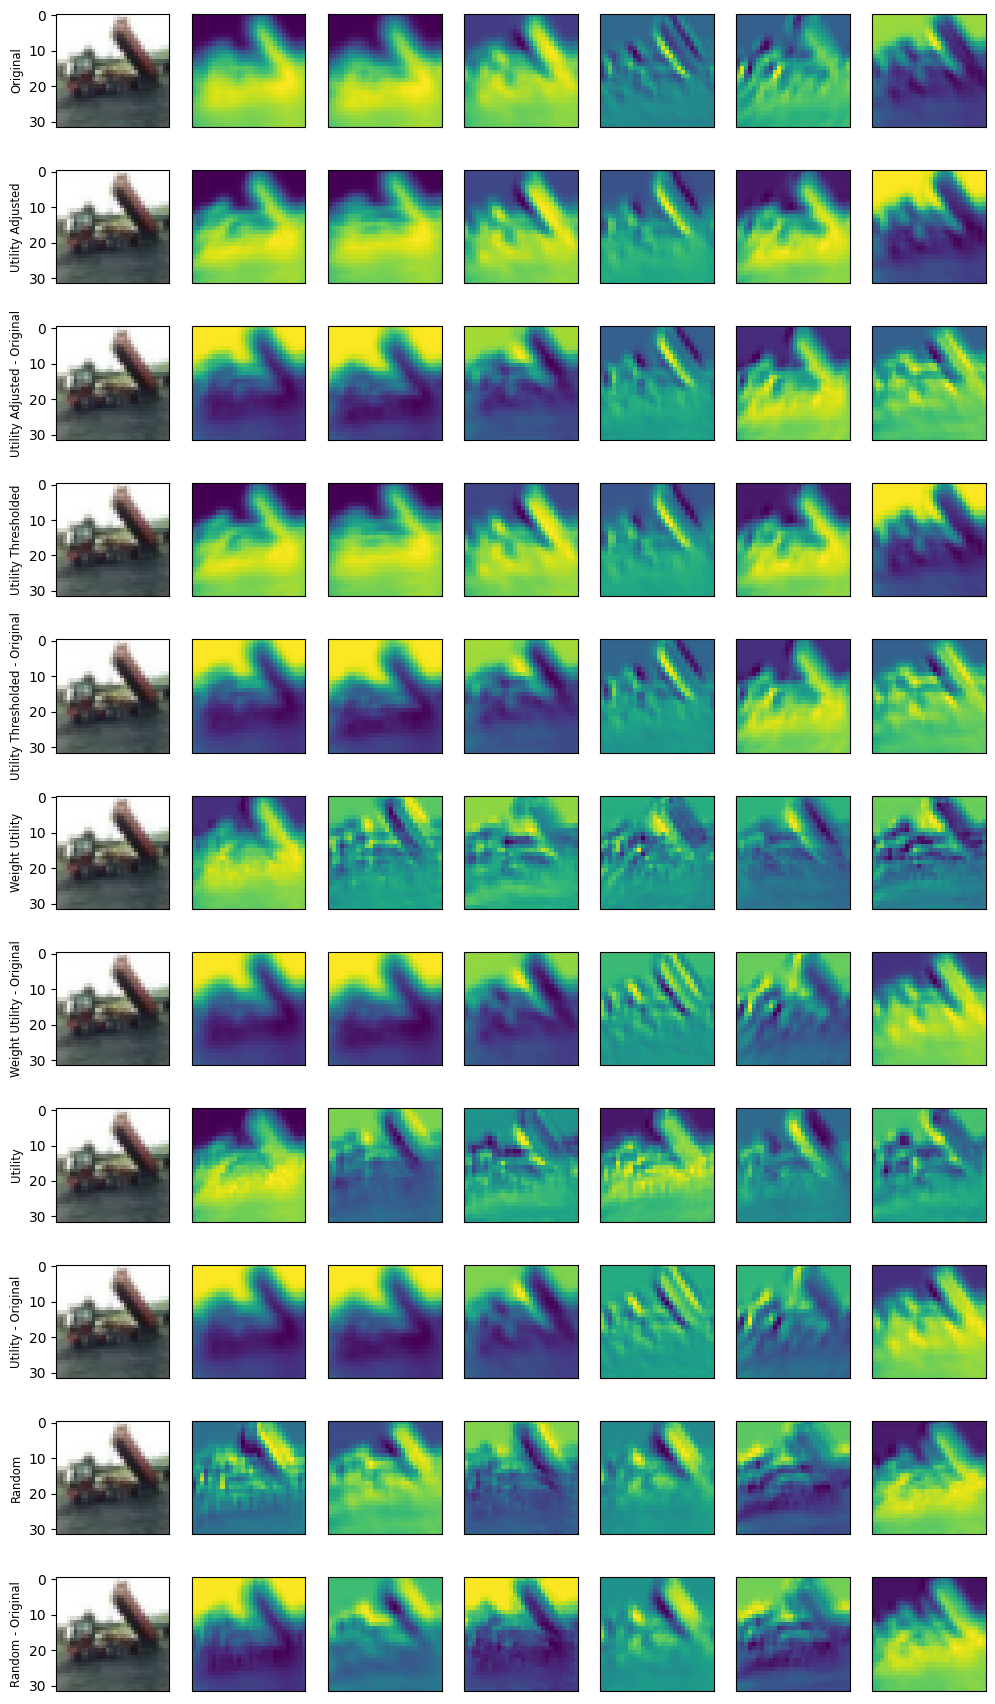

In [57]:
img = 2

model = ConvolutionalNetworkReLUWithHooks()
load_path = "results/model_upgd_fo_global_label_permuted_cifar10_stats_final.pth"
model = load_model(model, load_path)

# Initialize the UPGD optimizer with the parameters of conv_1
optimizer = UPGD(model.parameters(), lr=1e-5, weight_decay=0.001, beta_utility=0.999, sigma=0.001)
conv_to_test = model.conv_1

# Perform a forward pass to get the gradients
output = model(torch.tensor(images[img:img+1]).permute(0, 3, 1, 2).float())
output = output.view(output.size(0), -1)  # Flatten the output tensor
labels_tensor = torch.tensor(labels).view(-1, 1).float()  # Reshape the labels tensor
loss = F.mse_loss(output, labels_tensor)
loss.backward()

# Use the optimizer to calculate the utility
optimizer.step()

# Extract the utility values
utilities = []
for param in conv_to_test.parameters():
	utilities.append(optimizer.state[param]['scaled_utility'].clone())

# Print the utility values
utility_adjusted_conv = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
utility_conv = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
utility_thres_conv = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
weight_conv = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
random_conv = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))

utility_adjusted_conv.load_state_dict(conv_to_test.state_dict())
utility_thres_conv.load_state_dict(conv_to_test.state_dict())
utility_conv.load_state_dict(conv_to_test.state_dict())

for i, utility in enumerate(utilities):

	if i == 0:
		utility_adjusted_conv.weight = nn.Parameter(utility_adjusted_conv.weight * utility)
		utility_conv.weight = nn.Parameter(utility)
		utility_thres_conv.weight = nn.Parameter(utility_thres_conv.weight * (utility > 0.7).float())
		utility_conv.weight = nn.Parameter(utility_conv.weight * weight_conv.weight)
		random_conv.weight = nn.Parameter(torch.randn_like(random_conv.weight))
	else:
		utility_adjusted_conv.bias = nn.Parameter(utility_adjusted_conv.bias * utility)
		utility_conv.bias = nn.Parameter(utility)
		utility_thres_conv.bias = nn.Parameter(utility_thres_conv.bias * (utility > 0.7).float())
		utility_conv.bias = nn.Parameter(utility_conv.bias * weight_conv.bias)
		random_conv.bias = nn.Parameter(torch.randn_like(random_conv.bias))

with torch.no_grad():
	kernel = conv_to_test.forward(torch.tensor(images).permute(0, 3, 1, 2).float())
	kernel_utility_adjusted = utility_adjusted_conv.forward(torch.tensor(images).permute(0, 3, 1, 2).float())
	kernel_utility = utility_conv.forward(torch.tensor(images).permute(0, 3, 1, 2).float())
	kernel_utility_thres = utility_thres_conv.forward(torch.tensor(images).permute(0, 3, 1, 2).float())
	kernel_weight = weight_conv.forward(torch.tensor(images).permute(0, 3, 1, 2).float())
	kernel_random = random_conv.forward(torch.tensor(images).permute(0, 3, 1, 2).float())

# Show the first 3 images
n_imgs = 6

to_show = [
	kernel[img].numpy(),
	kernel_utility_adjusted[img].numpy(),
	kernel_utility_adjusted[img].numpy() - kernel[img].numpy(),
	kernel_utility_thres[img].numpy(),
	kernel_utility_thres[img].numpy() - kernel[img].numpy(),
	kernel_weight[img].numpy(),
	kernel_weight[img].numpy() - kernel[img].numpy(),
	kernel_utility[img].numpy(),
	kernel_utility[img].numpy() - kernel[img].numpy(),
	kernel_random[img].numpy(),
	kernel_random[img].numpy() - kernel[img].numpy(),
]
row_titles = [
	'Original',
	'Utility Adjusted', # Original weights adjusted by utility
	'Utility Adjusted - Original', 
	'Utility Thresholded', # Original weights multiplied by utility thresholded at 0.5
	'Utility Thresholded - Original', 
	'Weight Utility', # Original weights multiplied by utility squared
	'Weight Utility - Original',
	'Utility', # Utility values
	'Utility - Original',
	'Random',
	'Random - Original',
]

n = len(to_show)

fig, axes = plt.subplots(n, n_imgs+1, figsize=(2 * n_imgs, 2 * n))

for i in range(n):
	for j in range(n_imgs+1):
		axes[i, j].xaxis.set_visible(False)
		axes[i, j].yaxis.set_visible(False)
		pass
	axes[i, 0].yaxis.set_visible(True)
	axes[i, 0].imshow(images[img])

# Determine the min and max values for the colorscale
# vmin = min(v.min() for v in to_show)
# vmax = max(v.max() for v in to_show)

for i in range(n_imgs):
	for j, v in enumerate(to_show):
		axes[j, i+1].imshow(v[i]) #, vmin=vmin, vmax=vmax)

for ax, row in zip(axes[:, 0], row_titles):
	ax.set_ylabel(row, size='small')

plt.show()

In [ ]:
imgs = [
	1, 2, 3, 4, 5, 6
]

model = ConvolutionalNetworkReLUWithHooks()
load_path = "results/model_upgd_fo_global_label_permuted_cifar10_stats_final.pth"
model = load_model(model, load_path)

# Initialize the UPGD optimizer with the parameters of conv_1
optimizer = UPGD(model.parameters(), lr=1e-5, weight_decay=0.001, beta_utility=0.999, sigma=0.001)
conv_to_test = model.conv_1

# Perform a forward pass to get the gradients
output = model(torch.tensor(images[imgs]).permute(0, 3, 1, 2).float())
output = output.view(output.size(0), -1)  # Flatten the output tensor
labels_tensor = torch.tensor(labels).view(-1, 1).float()  # Reshape the labels tensor
loss = F.mse_loss(output, labels_tensor)
loss.backward()

# Use the optimizer to calculate the utility
optimizer.step()

# Extract the utility values
utilities = []
for param in conv_to_test.parameters():
	utilities.append(optimizer.state[param]['scaled_utility'].clone())

# Print the utility values
utility_adjusted_conv = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
utility_conv = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
utility_thres_conv = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
weight_conv = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
random_conv = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))

utility_adjusted_conv.load_state_dict(conv_to_test.state_dict())
utility_thres_conv.load_state_dict(conv_to_test.state_dict())
utility_conv.load_state_dict(conv_to_test.state_dict())

for i, utility in enumerate(utilities):

	if i == 0:
		utility_adjusted_conv.weight = nn.Parameter(utility_adjusted_conv.weight * utility)
		utility_conv.weight = nn.Parameter(utility)
		utility_thres_conv.weight = nn.Parameter(utility_thres_conv.weight * (utility > 0.7).float())
		utility_conv.weight = nn.Parameter(utility_conv.weight * weight_conv.weight)
		random_conv.weight = nn.Parameter(torch.randn_like(random_conv.weight))
	else:
		utility_adjusted_conv.bias = nn.Parameter(utility_adjusted_conv.bias * utility)
		utility_conv.bias = nn.Parameter(utility)
		utility_thres_conv.bias = nn.Parameter(utility_thres_conv.bias * (utility > 0.7).float())
		utility_conv.bias = nn.Parameter(utility_conv.bias * weight_conv.bias)
		random_conv.bias = nn.Parameter(torch.randn_like(random_conv.bias))

with torch.no_grad():
	kernel = conv_to_test.forward(torch.tensor(images).permute(0, 3, 1, 2).float())
	kernel_utility_adjusted = utility_adjusted_conv.forward(torch.tensor(images).permute(0, 3, 1, 2).float())
	kernel_utility = utility_conv.forward(torch.tensor(images).permute(0, 3, 1, 2).float())
	kernel_utility_thres = utility_thres_conv.forward(torch.tensor(images).permute(0, 3, 1, 2).float())
	kernel_weight = weight_conv.forward(torch.tensor(images).permute(0, 3, 1, 2).float())
	kernel_random = random_conv.forward(torch.tensor(images).permute(0, 3, 1, 2).float())

# Show the first 3 images
n_imgs = 6

to_show = [
	kernel[img].numpy(),
	kernel_utility_adjusted[img].numpy(),
	kernel_utility_adjusted[img].numpy() - kernel[img].numpy(),
	kernel_utility_thres[img].numpy(),
	kernel_utility_thres[img].numpy() - kernel[img].numpy(),
	kernel_weight[img].numpy(),
	kernel_weight[img].numpy() - kernel[img].numpy(),
	kernel_utility[img].numpy(),
	kernel_utility[img].numpy() - kernel[img].numpy(),
	kernel_random[img].numpy(),
	kernel_random[img].numpy() - kernel[img].numpy(),
]
row_titles = [
	'Original',
	'Utility Adjusted', # Original weights adjusted by utility
	'Utility Adjusted - Original', 
	'Utility Thresholded', # Original weights multiplied by utility thresholded at 0.5
	'Utility Thresholded - Original', 
	'Weight Utility', # Original weights multiplied by utility squared
	'Weight Utility - Original',
	'Utility', # Utility values
	'Utility - Original',
	'Random',
	'Random - Original',
]

n = len(to_show)

fig, axes = plt.subplots(n, n_imgs+1, figsize=(2 * n_imgs, 2 * n))

for i in range(n):
	for j in range(n_imgs+1):
		axes[i, j].xaxis.set_visible(False)
		axes[i, j].yaxis.set_visible(False)
		pass
	axes[i, 0].yaxis.set_visible(True)
	axes[i, 0].imshow(images[img])

# Determine the min and max values for the colorscale
vmin = min(v.min() for v in to_show)
vmax = max(v.max() for v in to_show)

for i in range(n_imgs):
	for j, v in enumerate(to_show):
		axes[j, i+1].imshow(v[i], vmin=vmin, vmax=vmax)

for ax, row in zip(axes[:, 0], row_titles):
	ax.set_ylabel(row, size='small')
    ax.set_title(f'Image {imgs[i]}')

plt.show()

In [12]:
for layer in model:
    print(layer._get_name())

Conv2d
MaxPool2d
Conv2d
MaxPool2d
Flatten
Linear
ReLU
Linear
ReLU
Linear


In [37]:
import plotly.graph_objects as go
# Plot the utility values
fig = go.Figure()

idx = 0
for layer in model:
	name = layer._get_name()
	for param, type in zip(layer.parameters(), ["weight", "bias"]):
		fig.add_trace(go.Box(y=optimizer.state[param]['scaled_utility'].flatten(), name=f'{name}_{idx}_{type}'))
	idx += 1

fig.update_yaxes(type="log")

fig.update_layout(
	updatemenus=[
		dict(
			buttons=list([
				dict(
					args=[{"yaxis.type": "log"}],
					label="Log",
					method="relayout"
				),
				dict(
					args=[{"yaxis.type": "linear"}],
					label="Linear",
					method="relayout"
				)
			]),
			direction="down",
			showactive=True,
		)
	]
)
fig.show()

# save to html
fig.write_html("results/utility_values.html")

torch.Size([16, 6, 5, 5])
dict_keys(['step', 'avg_utility', 'scaled_utility'])


/var/folders/9_/ltxb073x343d3wnstb03n2nr0000gn/T/ipykernel_93857/595121149.py:23: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



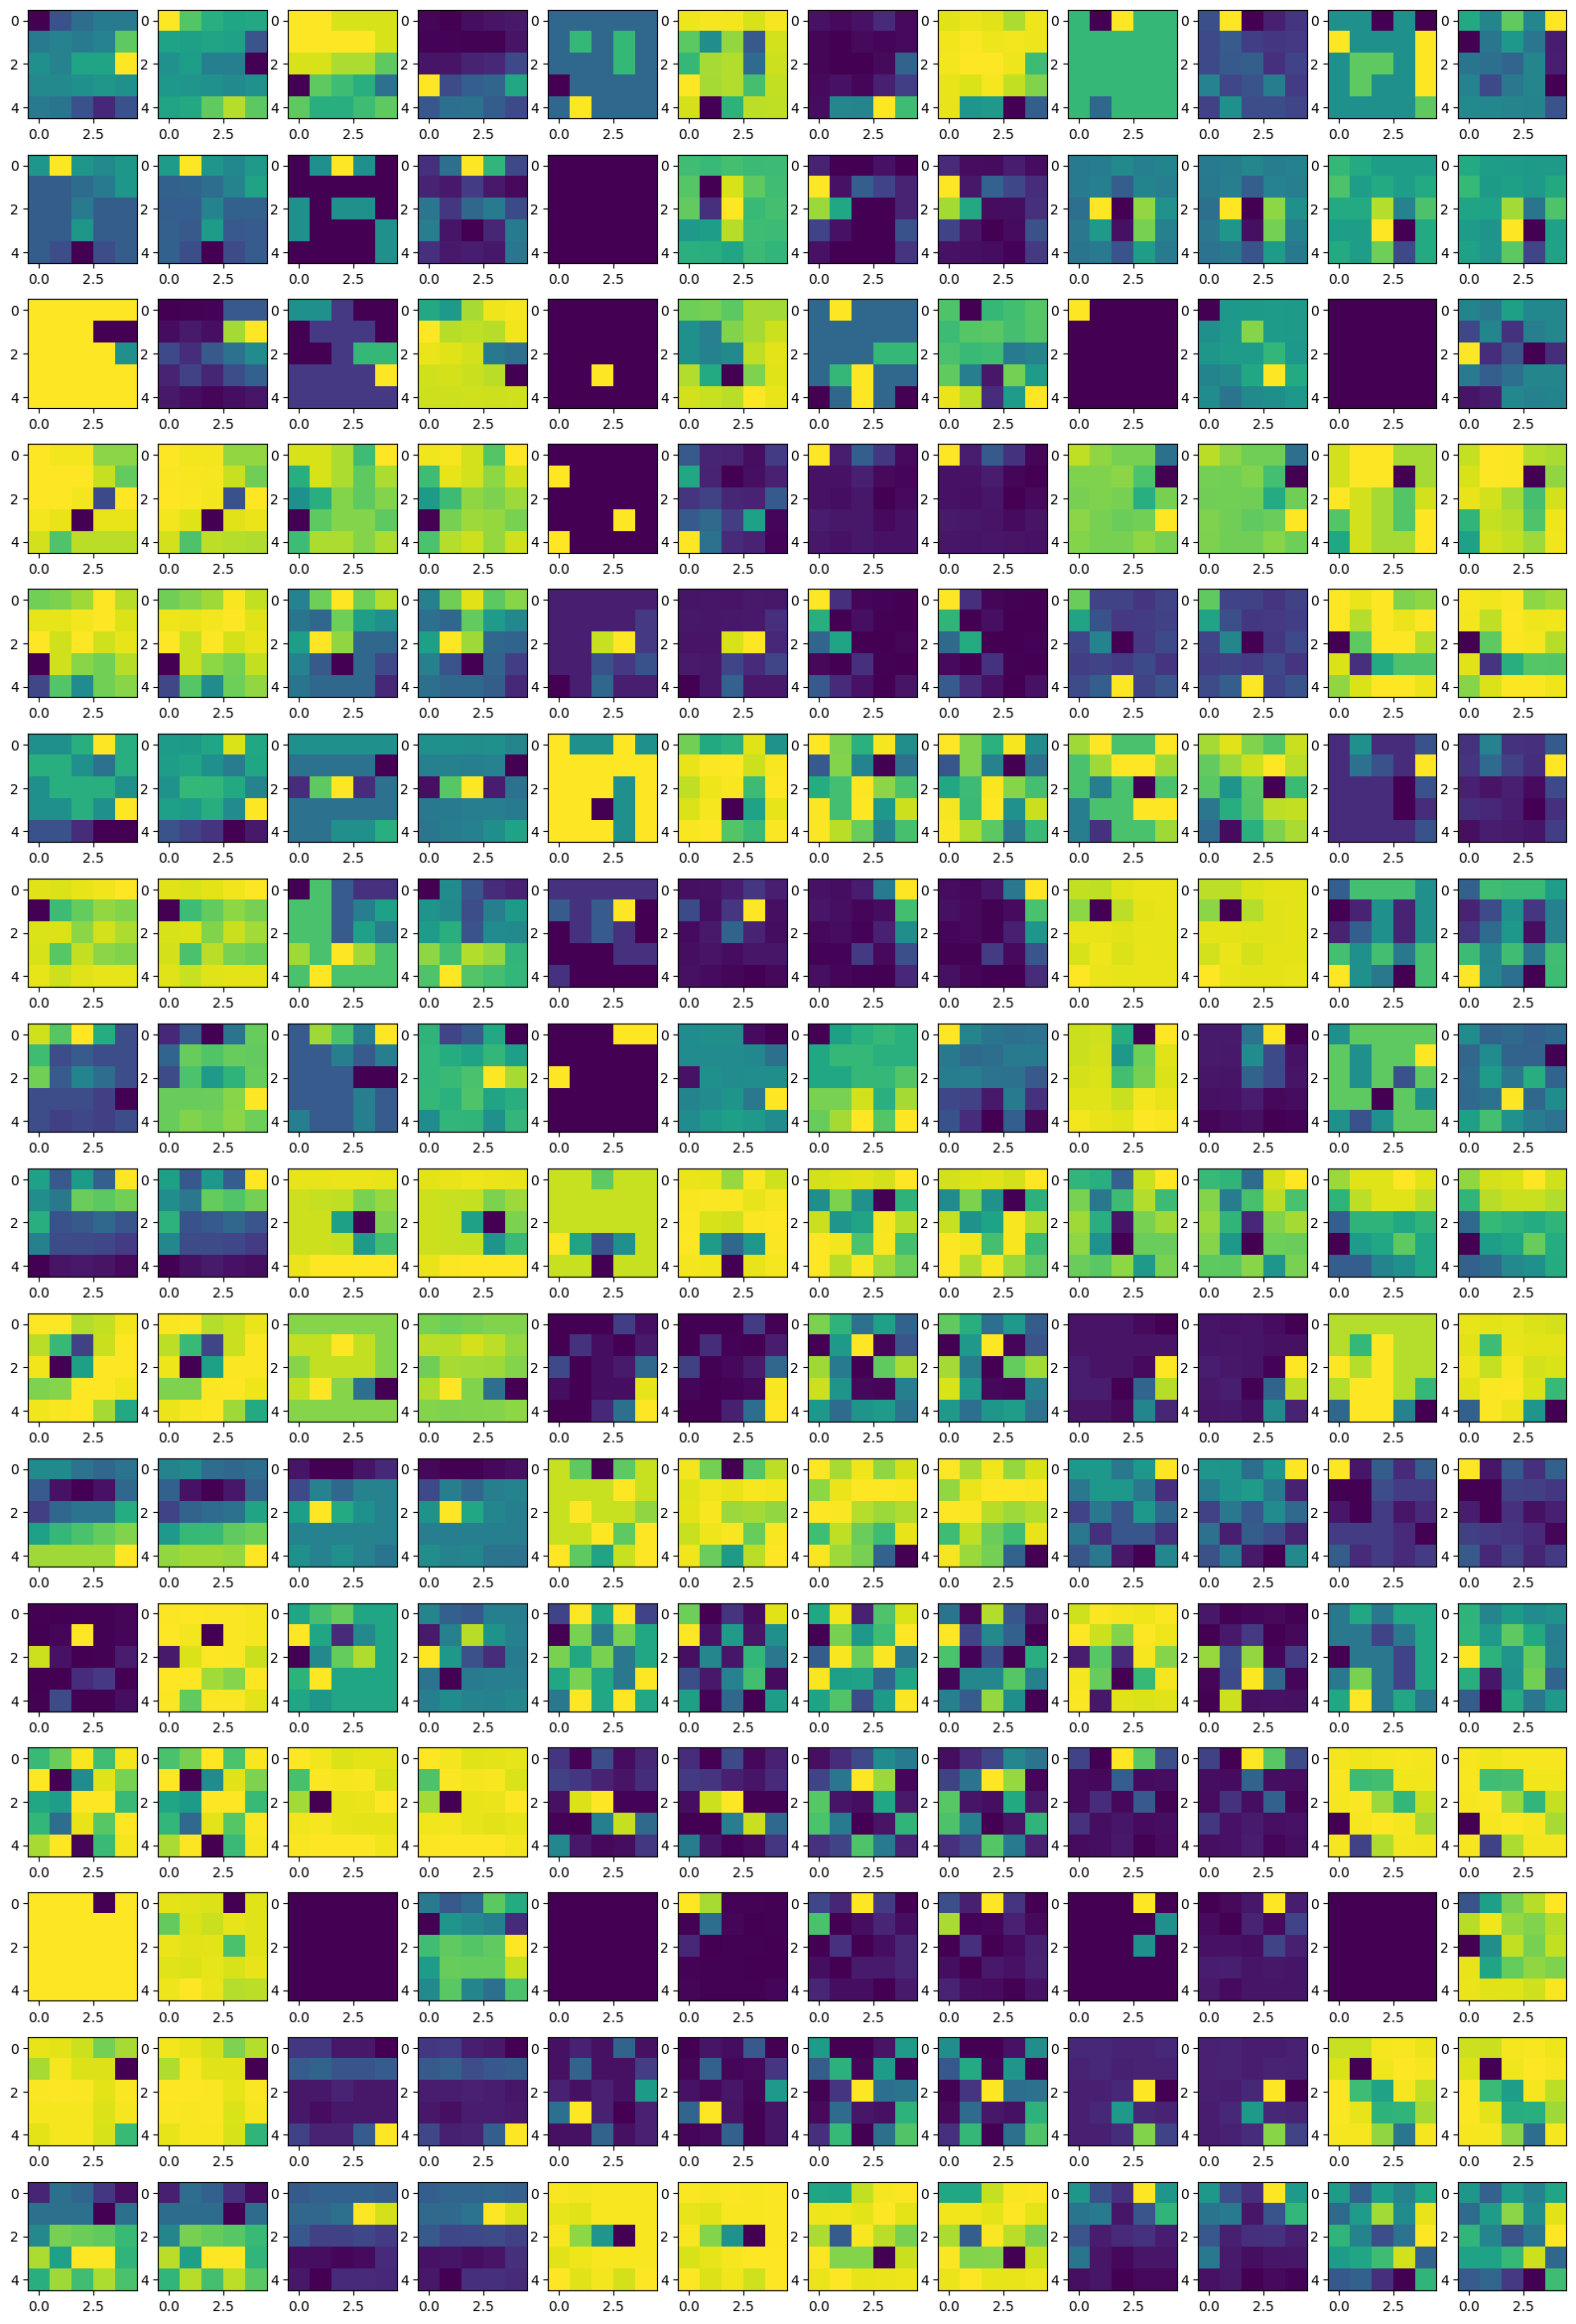

In [38]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(16, 12, figsize=(20, 30))

skip = True
for layer in model:
	name = layer._get_name()
	if (name != "Conv2d"):
		continue
	if skip:
		skip = False
		continue
	for param in layer.parameters():
		print(optimizer.state[param]['scaled_utility'].shape)
		print((optimizer.state[param]).keys())
		for i in range(param.shape[0]):
			for j in range(param.shape[1]):
				axes[i, j*2].imshow(optimizer.state[param]['scaled_utility'][i, j].numpy())
				axes[i, j*2+1].imshow(param[i, j].detach().numpy())
		break
	break

fig.show()

In [50]:
# calculate the model accuracy

def calculate_accuracy(model, images, labels):
    with torch.no_grad():
        output = model(torch.tensor(images).permute(0, 3, 1, 2).float())
        output = output.view(output.size(0), -1)  # Flatten the output tensor
        labels_tensor = torch.tensor(labels).view(-1, 1).float()  # Reshape the labels tensor
        loss = F.mse_loss(output, labels_tensor)
        return loss
    
print(calculate_accuracy(model, images, labels))

# Create a model with the utility adjusted weights
model_utility_adjusted = ConvolutionalNetworkReLUWithHooks()

utilities = [
    optimizer.state[model.conv_1.weight]['scaled_utility'],
    optimizer.state[model.conv_1.bias]['scaled_utility'],
    optimizer.state[model.conv_2.weight]['scaled_utility'],
    optimizer.state[model.conv_2.bias]['scaled_utility'],
    optimizer.state[model.linear_1.weight]['scaled_utility'],
    optimizer.state[model.linear_1.bias]['scaled_utility'],
    optimizer.state[model.linear_2.weight]['scaled_utility'],
    optimizer.state[model.linear_2.bias]['scaled_utility'],
    optimizer.state[model.linear_3.weight]['scaled_utility'],
    optimizer.state[model.linear_3.bias]['scaled_utility'],
]

# multiply the weights with the utility values
with torch.no_grad():
    model_utility_adjusted.conv_1.weight = nn.Parameter(model_utility_adjusted.conv_1.weight * utilities[0])
    model_utility_adjusted.conv_1.bias = nn.Parameter(model_utility_adjusted.conv_1.bias * utilities[1])
    model_utility_adjusted.conv_2.weight = nn.Parameter(model_utility_adjusted.conv_2.weight * utilities[2])
    model_utility_adjusted.conv_2.bias = nn.Parameter(model_utility_adjusted.conv_2.bias * utilities[3])
    model_utility_adjusted.linear_1.weight = nn.Parameter(model_utility_adjusted.linear_1.weight * utilities[4])
    model_utility_adjusted.linear_1.bias = nn.Parameter(model_utility_adjusted.linear_1.bias * utilities[5])
    model_utility_adjusted.linear_2.weight = nn.Parameter(model_utility_adjusted.linear_2.weight * utilities[6])
    model_utility_adjusted.linear_2.bias = nn.Parameter(model_utility_adjusted.linear_2.bias * utilities[7])
    model_utility_adjusted.linear_3.weight = nn.Parameter(model_utility_adjusted.linear_3.weight * utilities[8])
    model_utility_adjusted.linear_3.bias = nn.Parameter(model_utility_adjusted.linear_3.bias * utilities[9])

print(calculate_accuracy(model_utility_adjusted, images, labels))

/var/folders/9_/ltxb073x343d3wnstb03n2nr0000gn/T/ipykernel_93857/2654486991.py:8: UserWarning:

Using a target size (torch.Size([10000, 1])) that is different to the input size (torch.Size([10000, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



tensor(28.5022)
tensor(29.2618)
